<a href="https://colab.research.google.com/github/GitMechub/HVAC-Duct_Sizing/blob/main/HVAC_Duct_Sizing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**HVAC Duct Sizing - v1.0.0**

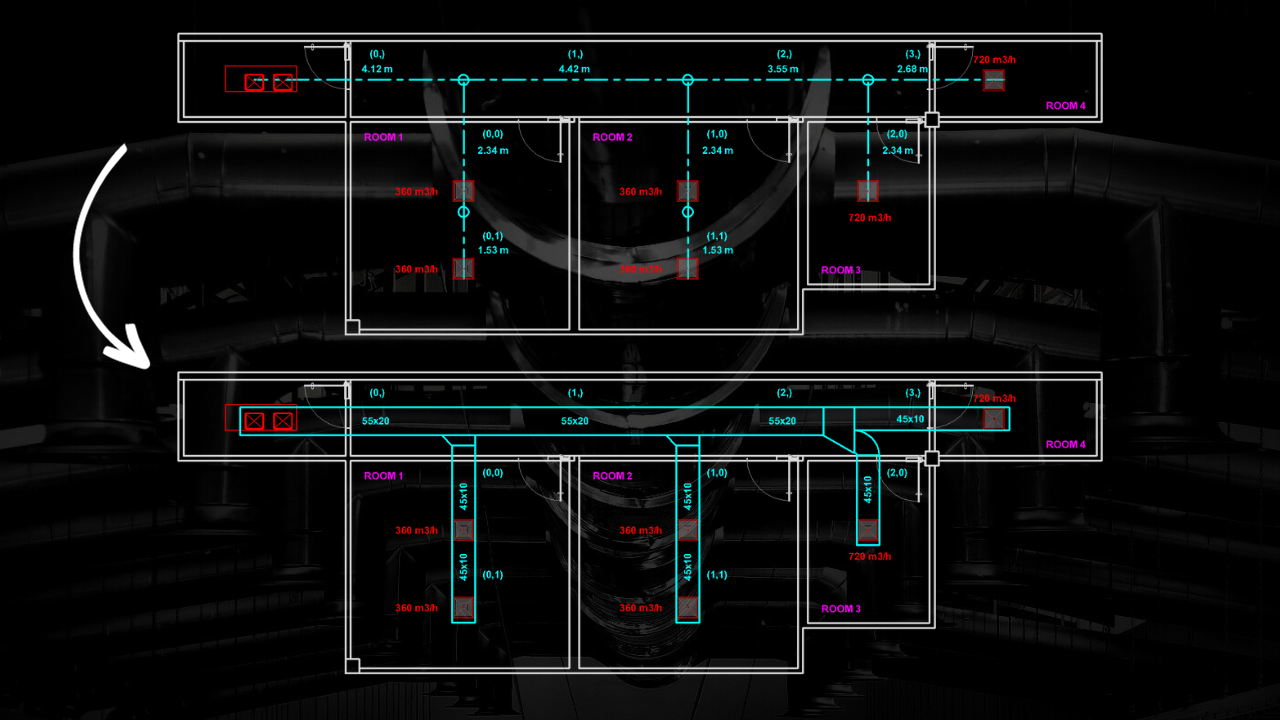

Please, subscribe to the channel [Mechub](https://youtube.com/@Mechub?sub_confirmation=1)
and check my [GitHub](https://github.com/GitMechub)

---

*Por favor, inscreva-se no canal: [Mechub](https://youtube.com/@Mechub?sub_confirmation=1) e visite o meu [GitHub](https://github.com/GitMechub)*


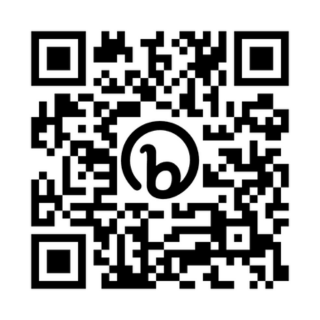

Link for the video explaining how to use the code:

---

*Link para o vídeo explicando como usar o código (legendas em potuguês):*

[![YouTube](https://img.shields.io/badge/YouTube-FF0000?style=for-the-badge&logo=youtube&logoColor=white)](https://www.youtube.com/watch?v=FLz8qtGiTjw)

# PACKS

In [ ]:
pip install scipy

In [ ]:
import numpy as np
import pandas as pd
import scipy.optimize as spo
from scipy.interpolate import interp1d
import math

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import random

# INPUT

Press Ctrl+F9 to run

*Pressione Ctrl+F9 para executar*

In [ ]:
##############

""" INPUT """

##############


set_terminals = [ (0,0),(0,1),(1,0),(1,1),(2,0),(3,) ]    # Location of each terminal (tuples) | Example: [ (0,0),(0,1),(1,0),(1,1),(2,0),(3,) ]

set_terminal_frates = [ 360,360,360,360,720,720 ]    # Terminal flow rate (m³/h)

section_length = [ 4.12, 2.34, 1.53, 4.42, 2.34, 1.53, 3.55, 2.34, 2.68 ]    # Duct length (m) for each section in ascending order | Example: for [ (0,),(0,0),(0,1),(1,),(1,0),(1,1),(2,),(2, 0),(3,) ] -> section_length = [ 10, 10, 5, 5, 5, 5, 5, 5, 5 ]


# Restrictions:

## Velocity restriction

set_duct_velocity_bounds = [4, 7]   # Main duct velocity (m/s) restriction interval [a, b] | Example: [4, 7]

set_branch_velocity_bounds = [1, 5]   # Secundary duct velocity (m/s) restriction interval [a, b] | Example: [3, 5]

##


## Height and width restrictions:   * Attention * : Do not set the upper limit of both restrictions too low.

W_restriction = [0.45, 2]   # Duct width (m) restriction interval [a, b] | Example: [0.2, 2]

H_restriction = [0.1, 0.5]   # Duct height (m) restriction interval [a, b] | Example: [0.15, 0.5]

##

#

# CODE

## Duct Sections

In [ ]:
#################################

""" ALLOCATING DUCT SECTIONS """

#################################


# Max number of divisions:
max_divisions = 0
for i in range(len(set_terminals)):
  if len(set_terminals[i]) > max_divisions:
    max_divisions = len(set_terminals[i])
#


# Creating sections list:
sections = []
for i in range(len(set_terminals)):
  sections.append(set_terminals[i])
#


# Identifying parent tuples and adding them to the 'sections' list:
def get_all_parent_tuples(tupla):
    all_parent_tuples = []
    for i in range(len(tupla) - 1):
        all_parent_tuples.append(tupla[:i + 1])
    return all_parent_tuples

for t in sections:
    all_parent_tuples = get_all_parent_tuples(t)
    for t in all_parent_tuples:
        if t not in sections:
            sections.append(t)
            set_terminal_frates.append(0)  # Adding a temporary flow rate value


# Sort:
# Sort the list based on the order of tuples
set_terminal_frates = [x for _, x in sorted(zip(sections, set_terminal_frates), key=lambda pair: pair[0], reverse=True)]

# Sort the numeric tuples in ascending order based on the first element of each tuple
sections = sorted(sections, reverse=True)
#


# Creating section flow rates list:
section_frates = []
for i in range(len(set_terminal_frates)):
  section_frates.append(set_terminal_frates[i])
#


# Identifying the previous tuple:
def previous_tuple(tupla):
  # Add 1 to the last number of the tuple
  new_element = tupla[-1] + 1

  # Create a new tuple with the last element incremented
  previous_tuple = tupla[:-1] + (new_element,)

  return previous_tuple
#


# Section Flow rates
for i in range(len(sections)):

  # Adding the flow rate from the previous section to the current one
  pre_tuple = previous_tuple(sections[i])
  if pre_tuple in sections:
    section_frates[i] = section_frates[i] + section_frates[sections.index(pre_tuple)]

  # Adding the flow rate from the first derivated section to the current one
  deriv_tuple = sections[i]+(0,)
  if deriv_tuple in sections:
    section_frates[i] = section_frates[i] + section_frates[sections.index(deriv_tuple)]


# Re-Sort:

# Sort the list based on the order of tuples
section_frates = [x for _, x in sorted(zip(sections, section_frates), key=lambda pair: pair[0], reverse=False)]

# Sort the numeric tuples in ascending order based on the first element of each tuple
sections = sorted(sections, reverse=False)
#


print(sections, section_frates)


[(0,), (0, 0), (0, 1), (1,), (1, 0), (1, 1), (2,), (2, 0), (3,)] [2880, 720, 360, 2160, 720, 360, 1440, 720, 720]


## Areas and Velocities

In [ ]:
# Sort based on the highest flow rate:

# Sort the list based on the descending order of flow rates
sections = [x for _, x in sorted(zip(section_frates, sections), key=lambda pair: pair[0], reverse=True)]

# Sort numeric tuples in descending order based on their first element
section_frates = sorted(section_frates, reverse=True)

# Flow rates in m³/s
section_frates_m3_s = [frate / 3600 for frate in section_frates]

# Number of sections
num_sections = len(section_frates)

# Bounds for the areas of each section (e.g., between 0.01 and 0.5 square meters)
bounds = [(0.01, 0.5) for _ in range(num_sections)]

# Bonds for the velocities of each section
velocity_bounds = [set_duct_velocity_bounds, set_branch_velocity_bounds]

# Generate new random initial conditions for optimization
initial_areas = np.random.uniform(0.01, 0.5, num_sections)


# Function to calculate velocities based on areas
def calculate_velocities(areas):
    section_velocities = [frate / area for frate, area in zip(section_frates_m3_s, areas)]
    return section_velocities


def related_tuples(tupla):
    # Initialize an empty list to store the tuples
    lista = []

    while len(tupla) > 0:
        # Append the current tuple to the list
        lista.append(tupla)
        # Subtract 1 from the last value of the tuple
        tupla = tupla[:-1] + (tupla[-1] - 1,)
        # If the last value of the tuple is less than 0, move to tuples with fewer indices
        if tupla[-1] < 0:
            tupla = tupla[:-1]

    return lista


# Objective function
def objective(areas, set_terminals,sections, velocity_bounds):
    total_plosses = []  # Total pressure losses for each exit (to calculate the maximum at the end)
    total_plosses_sections = []  # Sections for each total pressure loss calculation (to locate the maximum at the end)
    hpf = []  # Friction loss (m)

    velocities = calculate_velocities(areas)
    mean_velocity = np.mean(velocities)

    # Pressure drop: Friction (trying to minimize pressure loss differences)
    for i in range(len(areas)):
        D_ = ((4 * areas[i]) / (math.pi)) ** 0.5  # Diameter (m)
        Reef = (velocities[i] * D_) / 1.46e-5  # Effective Reynolds (air: 1.22 kg/m³ | 1.46e-5 m²/s)
        roughness_ratio = 0.09 / (D_ * 1000)  # Roughness ratio (epsilon: 0.09 mm for Galvanized steel)
        ff_ = 0.11 * ((roughness_ratio + (68 / Reef)) ** 0.25)  # Friction factor - Altshul-Tsal Equation
        if ff_ >= 0.018:
            ff = ff_
        else:
            ff = 0.85 * ff_ + 0.0028
        hpf.append(ff * (section_length[i] / D_) * ((velocities[i] ** 2) / (2 * 9.81)))  # Perda de fricção (m)

    # Calculating pressure losses for each outlet:
    for i in range(len(set_terminals)):
        related_tuples_list = related_tuples(set_terminals[i])
        total_plosses_sections.append(related_tuples_list)
        plosses_section = 0
        for j in range(len(related_tuples_list)):
            section_index = sections.index(related_tuples_list[j])
            plosses_section = plosses_section + hpf[section_index]
        total_plosses.append(plosses_section)

    # Total pressure loss result (maximum and minimum values):
    max_plosses = max(total_plosses)
    min_plosses = min(total_plosses)
    error_plosses = ((max_plosses - min_plosses) / max_plosses)

    # Velocity bounds penalty
    velocity_bounds_penalty = 0
    for i in range(len(sections)):
      if len(sections[i]) == 1:
        if velocities[i] > velocity_bounds[0][1] or velocities[i] < velocity_bounds[0][0]:
          velocity_bounds_penalty = velocity_bounds_penalty + (max(abs(velocities[i] - velocity_bounds[0][1]), abs(velocities[i] - velocity_bounds[0][0])))/velocities[i]

      else:
        if velocities[i] > velocity_bounds[1][1] or velocities[i] < velocity_bounds[1][0]:
          velocity_bounds_penalty = velocity_bounds_penalty + (max(abs(velocities[i] - velocity_bounds[1][1]), abs(velocities[i] - velocity_bounds[1][0])))/velocities[i]

    # Penalty if velocity is two times greater or smaller than the next section
    velocity_penalty = sum(max(0, v - 2 * velocities[i + 1]) + max(0, velocities[i + 1] * 2 - v) for i, v in enumerate(velocities[:-1]))
    velocity_penalty = velocity_penalty/(mean_velocity*len(sections))

    # Penalty for deviation from the desired velocity (5 m/s)
    #velocity_deviation_penalty = abs(mean_velocity - 5)
    #velocity_deviation_penalty = velocity_deviation_penalty/mean_velocity

    #print(error_plosses, velocity_penalty, velocity_bounds_penalty)
    penalty_error = error_plosses + velocity_penalty + velocity_bounds_penalty

    return penalty_error


# Create a constraint object for area constraints
constraints = []
for i in range(len(section_frates) - 1):
  constraints.append({'type': 'ineq', 'fun': lambda areas, i=i: areas[i] - areas[i+1]})
  constraints.append({'type': 'ineq', 'fun': lambda areas, i=i: 2 * areas[i+1] - areas[i]})


# Number of optimization attempts
num_attempts = 400  # You can adjust this number as needed

best_solution = None
best_final_velocities = None
best_optimized_areas = None
best_penalty_error = float('inf')  # Initialize with a high value to find the best result

for attempt in range(num_attempts):
    # Generate new random initial conditions for optimization
    initial_areas = np.random.uniform(0.01, 0.5, num_sections)

    # Perform optimization again with the new initial conditions
    result = spo.minimize(objective, initial_areas, args=(set_terminals,sections, velocity_bounds), bounds=bounds, constraints=constraints)

    # Check if the optimization was successful and if the solution is better than the previous one
    if result.success:
        optimized_areas = result.x
        final_velocities = calculate_velocities(optimized_areas)
        mean_velocity = np.mean(final_velocities)

        # If the new solution is better, update the best results
        penalty_error = objective(optimized_areas, set_terminals, sections, velocity_bounds)
        if penalty_error < best_penalty_error:
            best_penalty_error = penalty_error
            best_solution = result
            best_optimized_areas = optimized_areas
            best_final_velocities = final_velocities
            best_mean_velocity = mean_velocity

# Check if any optimization was successful
if best_solution is not None:
    print("Best solution found:")
    print("Optimized areas for each section (square meters):")
    for i, area in enumerate(best_optimized_areas):
        print(f"Section {i + 1}: {area:.2f} m²")

    print(f"Final average velocity: {best_mean_velocity:.2f} m/s")
else:
    print("No successful optimizations.")

final_velocities = best_final_velocities
optimized_areas = best_optimized_areas


print(final_velocities)
print(sections)
print(section_frates)
print(optimized_areas)

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Best solution found:
Optimized areas for each section (square meters):
Section 1: 0.11 m²
Section 2: 0.11 m²
Section 3: 0.10 m²
Section 4: 0.05 m²
Section 5: 0.05 m²
Section 6: 0.05 m²
Section 7: 0.05 m²
Section 8: 0.05 m²
Section 9: 0.05 m²
Final average velocity: 4.03 m/s
[6.99779034821506, 5.248342761768082, 4.000000655792946, 4.000002604762839, 4.000002111634284, 4.000002535033209, 4.000001318433306, 2.0233740037513326, 2.0233730819228835]
[(0,), (1,), (2,), (0, 0), (1, 0), (2, 0), (3,), (0, 1), (1, 1)]
[2880, 2160, 1440, 720, 720, 720, 720, 360, 360]
[0.1143218  0.1143218  0.09999998 0.04999997 0.04999997 0.04999997
 0.04999998 0.0494224  0.04942242]


## Duct Dimensions

In [ ]:
#######################

""" DUCT DIMENSIONS """

#######################


# List of height and width options:
W_options =  [round(i, 2) for i in np.arange(0.1, 1.05, 0.05)]
for i in np.arange(1.1, 2.1, 0.1):
  W_options.append(round(i,2))
H_options = W_options

H_options = [x for x in H_options if x >= H_restriction[0] and x <= H_restriction[1]]
W_options = [x for x in W_options if x >= W_restriction[0] and x <= W_restriction[1]]
#


best_combinations = []

for area_target in optimized_areas:
    best_diff = float('inf')  # Initialize the best difference as infinity
    best_combination = None

    for W in W_options:
        for H in H_options:
            area_calculated = W * H  # Calculate the area for the current combination

            # Check if the width of the previous section is less than or equal to the width of the current section
            if best_combination is not None and W <= best_combination[0]:
                continue

            # Check if the height of the previous section is less than or equal to the height of the current section
            if best_combination is not None and H <= best_combination[1]:
                continue

            diff = abs(area_calculated - area_target)  # Calculate the difference

            # Check if this combination is the best one so far
            if diff < best_diff:
                best_diff = diff
                best_combination = (W, H)

    best_combinations.append(best_combination)


# best_combinations now contains the best combinations for each element in optimized_areas
print("Best W x H combinations for each target area:")
for i, (W, H) in enumerate(best_combinations):
    print(f"Target Area {i + 1}: Width = {W}, Height = {H}")

section_width = []
section_height = []
for i in range(len(best_combinations)):
  section_width.append(best_combinations[i][0])
  section_height.append(best_combinations[i][1])


# Re-Sort:

# Sort the list based on the order of tuples
section_frates = [x for _, x in sorted(zip(sections, section_frates), key=lambda pair: pair[0], reverse=False)]

# Sort the list based on the order of tuples
optimized_areas = [x for _, x in sorted(zip(sections, optimized_areas), key=lambda pair: pair[0], reverse=False)]

# Sort the list based on the order of tuples
final_velocities = [x for _, x in sorted(zip(sections, final_velocities), key=lambda pair: pair[0], reverse=False)]

# Sort the list based on the order of tuples
section_width = [x for _, x in sorted(zip(sections, section_width), key=lambda pair: pair[0], reverse=False)]

# Sort the list based on the order of tuples
section_height = [x for _, x in sorted(zip(sections, section_height), key=lambda pair: pair[0], reverse=False)]

# Sort the numeric tuples in ascending order based on the first element of each tuple
sections = sorted(sections, reverse=False)
#


# Recalculating section areas and velocities based on width and height values:

for i in range(len(section_frates)):

  optimized_areas[i] = section_width[i]*section_height[i]

  final_velocities[i] = section_frates[i]/(optimized_areas[i]*3600)
#


# Calculating diameter for circular duct sections (m):

section_diameter = []

for i in range(len(section_frates)):

  section_diameter.append((4*optimized_areas[i]/math.pi)**0.5)
#


final_mean_velocity = np.mean(final_velocities)


Best W x H combinations for each target area:
Target Area 1: Width = 0.55, Height = 0.2
Target Area 2: Width = 0.55, Height = 0.2
Target Area 3: Width = 0.55, Height = 0.2
Target Area 4: Width = 0.45, Height = 0.1
Target Area 5: Width = 0.45, Height = 0.1
Target Area 6: Width = 0.45, Height = 0.1
Target Area 7: Width = 0.45, Height = 0.1
Target Area 8: Width = 0.45, Height = 0.1
Target Area 9: Width = 0.45, Height = 0.1


## Pressure Losses

In [ ]:
#######################

""" PRESSURE LOSSES """

#######################


total_plosses = []    # Total pressure losses for each exit (to calculate the maximum at the end)
total_plosses_sections = []   # Sections for each total pressure loss calculation (to locate the maximum at the end)
hpf = []    # Friction loss (m)


# Pressure drop: Friction
for i in range(len(section_frates)):

  Dh = (4*optimized_areas[i])/((2*section_height[i])+(2*section_width[i]))    # Hydraulic diameter (m)
  Def = 1.3*((section_height[i]*section_width[i])**(0.625))/((section_height[i]+section_width[i])**(0.25))   # Effective diameter (m)

  Reef = (final_velocities[i]*Def)/1.46e-5    # Effective Reynolds (air: 1.22 kg/m³ | 1.46e-5 m²/s)

  roughness_ratio = 0.09/(Def*1000)   # Roughness ratio (epsilon: 0.09 mm for Galvanized steel)

  ff_ = 0.11*((roughness_ratio + (68/Reef))**0.25)   # Friction factor - Altshul-Tsal Equation
  if ff_ >= 0.018:
    ff = ff_
  else:
    ff = 0.85*ff_+0.0028

  print("Friction Factor: ",ff)

  hpf.append( ff*(section_length[i]/Dh)*((final_velocities[i]**2)/(2*9.81)) )   # Friction loss (m)


# Calculating pressure losses for each outlet:

def related_tuples(tupla):
    # Initialize an empty list to store the tuples
    lista = []

    while len(tupla) > 0:
        # Append the current tuple to the list
        lista.append(tupla)
        # Subtract 1 from the last value of the tuple
        tupla = tupla[:-1] + (tupla[-1] - 1,)
        # If the last value of the tuple is less than 0, move to tuples with fewer indices
        if tupla[-1] < 0:
            tupla = tupla[:-1]

    return lista


for i in range(len(set_terminals)):

  related_tuples_list = related_tuples(set_terminals[i])
  total_plosses_sections.append(related_tuples_list)

  plosses_section = 0
  for j in range(len(related_tuples_list)):

    section_index = sections.index(related_tuples_list[j])
    plosses_section = plosses_section + hpf[section_index]

  total_plosses.append(plosses_section)


# Total pressure loss result (maximum and minimum values):

section_index = sections.index(related_tuples_list[j])

max_plosses = max(total_plosses)
max_plosses_sections = total_plosses_sections[total_plosses.index(max_plosses)]

min_plosses = min(total_plosses)
min_plosses_sections = total_plosses_sections[total_plosses.index(min_plosses)]

error_plosses = ((max_plosses - min_plosses)/max_plosses)*100   # Error (%)
#


print('\n',total_plosses)
print(total_plosses_sections)
print(hpf)
print('\n',max_plosses, max_plosses_sections)

Friction Factor:  0.017696057488606677
Friction Factor:  0.021435463511608566
Friction Factor:  0.024522237593572836
Friction Factor:  0.018345439353527535
Friction Factor:  0.021435463511608566
Friction Factor:  0.024522237593572836
Friction Factor:  0.019718015655718464
Friction Factor:  0.021435463511608566
Friction Factor:  0.021435463511608566

 [0.978657456241912, 1.0363670046996223, 1.397843771676563, 1.4555533201342734, 1.5586732865794792, 1.6035135274430845]
[[(0, 0), (0,)], [(0, 1), (0, 0), (0,)], [(1, 0), (1,), (0,)], [(1, 1), (1, 0), (1,), (0,)], [(2, 0), (2,), (1,), (0,)], [(3,), (2,), (1,), (0,)]]
[0.6700510926512173, 0.3086063635906947, 0.05770954845771031, 0.4191863154346511, 0.3086063635906947, 0.05770954845771031, 0.1608295149029161, 0.3086063635906947, 0.3534466044543]

 1.6035135274430845 [(3,), (2,), (1,), (0,)]


## Plot

In [ ]:
#############

""" PLOT """

#############


table_final_velocities = [round(final_velocities[i], 2) for i in range(len(final_velocities))]
table_hpf = [round(hpf[i], 2) for i in range(len(hpf))]
section_diameter = [round(section_diameter[i], 2) for i in range(len(section_diameter))]
table_optimized_areas = [round(optimized_areas[i], 3) for i in range(len(optimized_areas))]


# Table:
table_results = go.Figure(data=[go.Table(header=dict(values=['Section','Flow rate [m³/h]', 'Velocity [m/s]', 'Area [m²]', 'Width [m]', 'Height [m]', 'Diam. (if circular) [m]', 'Length [m]','Friction loss [m]'], height=40, align=['center'], line_color='darkslategray', fill_color='royalblue',font=dict(color='white', size=16)),
                cells=dict(values=[ sections, section_frates, table_final_velocities, table_optimized_areas, section_width, section_height, section_diameter, section_length, table_hpf ], line_color='darkslategray', height = 30, fill_color=['lightskyblue','lightcyan'], font=dict(color='darkslategray', size=14) ))
                    ], layout=go.Layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)'
)
                        )

table_results.update_layout(title='DUCT DESIGN', titlefont=dict(color='royalblue', size=28), height=500 )
#


# More results:

structural_area = sum([(2*section_length[i]*(section_height[i] + section_width[i])) for i in range(len(sections))]) # Structural material area of the ducts (m²)
structural_area_circular = sum([(section_length[i]*(math.pi*section_diameter[i])) for i in range(len(sections))]) # Structural material area of the ducts, if circular (m²)


def extra_results(max_plosses, max_plosses_sections, final_mean_velocity, structural_area):
  print('\n- Max friction loss =',max_plosses,'m (',max_plosses*9.81*1.22,'Pa )', ', for (outlet <- inlet): ', max_plosses_sections,'\n')    # air: 1.22 kg/m³ | gravity: 9.81 m/s²
  print('- Min friction loss =',min_plosses,'m (',min_plosses*9.81*1.22,'Pa )', ', for (outlet <- inlet): ', min_plosses_sections,'\n\n')    # air: 1.22 kg/m³ | gravity: 9.81 m/s²
  print(f"- Mean velocity = {final_mean_velocity:.2f} m/s\n\n")
  print(f"- Structural material area of the ducts = {round(structural_area,0)} m²\n")
  print(f"- Structural material area of the ducts (if circular) = {round(structural_area_circular,0)} m²\n")
#


# OUTPUT

In [ ]:
table_results.show()
extra_results(max_plosses, max_plosses_sections, final_mean_velocity, structural_area)


- Max friction loss = 1.6035135274430845 m ( 19.191170599144325 Pa ) , for (outlet <- inlet):  [(3,), (2,), (1,), (0,)] 

- Min friction loss = 0.978657456241912 m ( 11.71276816779445 Pa ) , for (outlet <- inlet):  [(0, 0), (0,)] 


- Mean velocity = 4.29 m/s


- Structural material area of the ducts = 32.0 m²

- Structural material area of the ducts (if circular) = 24.0 m²



# EXAMPLE

**1**

Set the air terminals, specify their flow rates and create a line representing the air ducts

------------------------------------------

*Defina os terminais de ar, especifique suas taxas de fluxo e crie uma linha para representar os dutos de ar.*

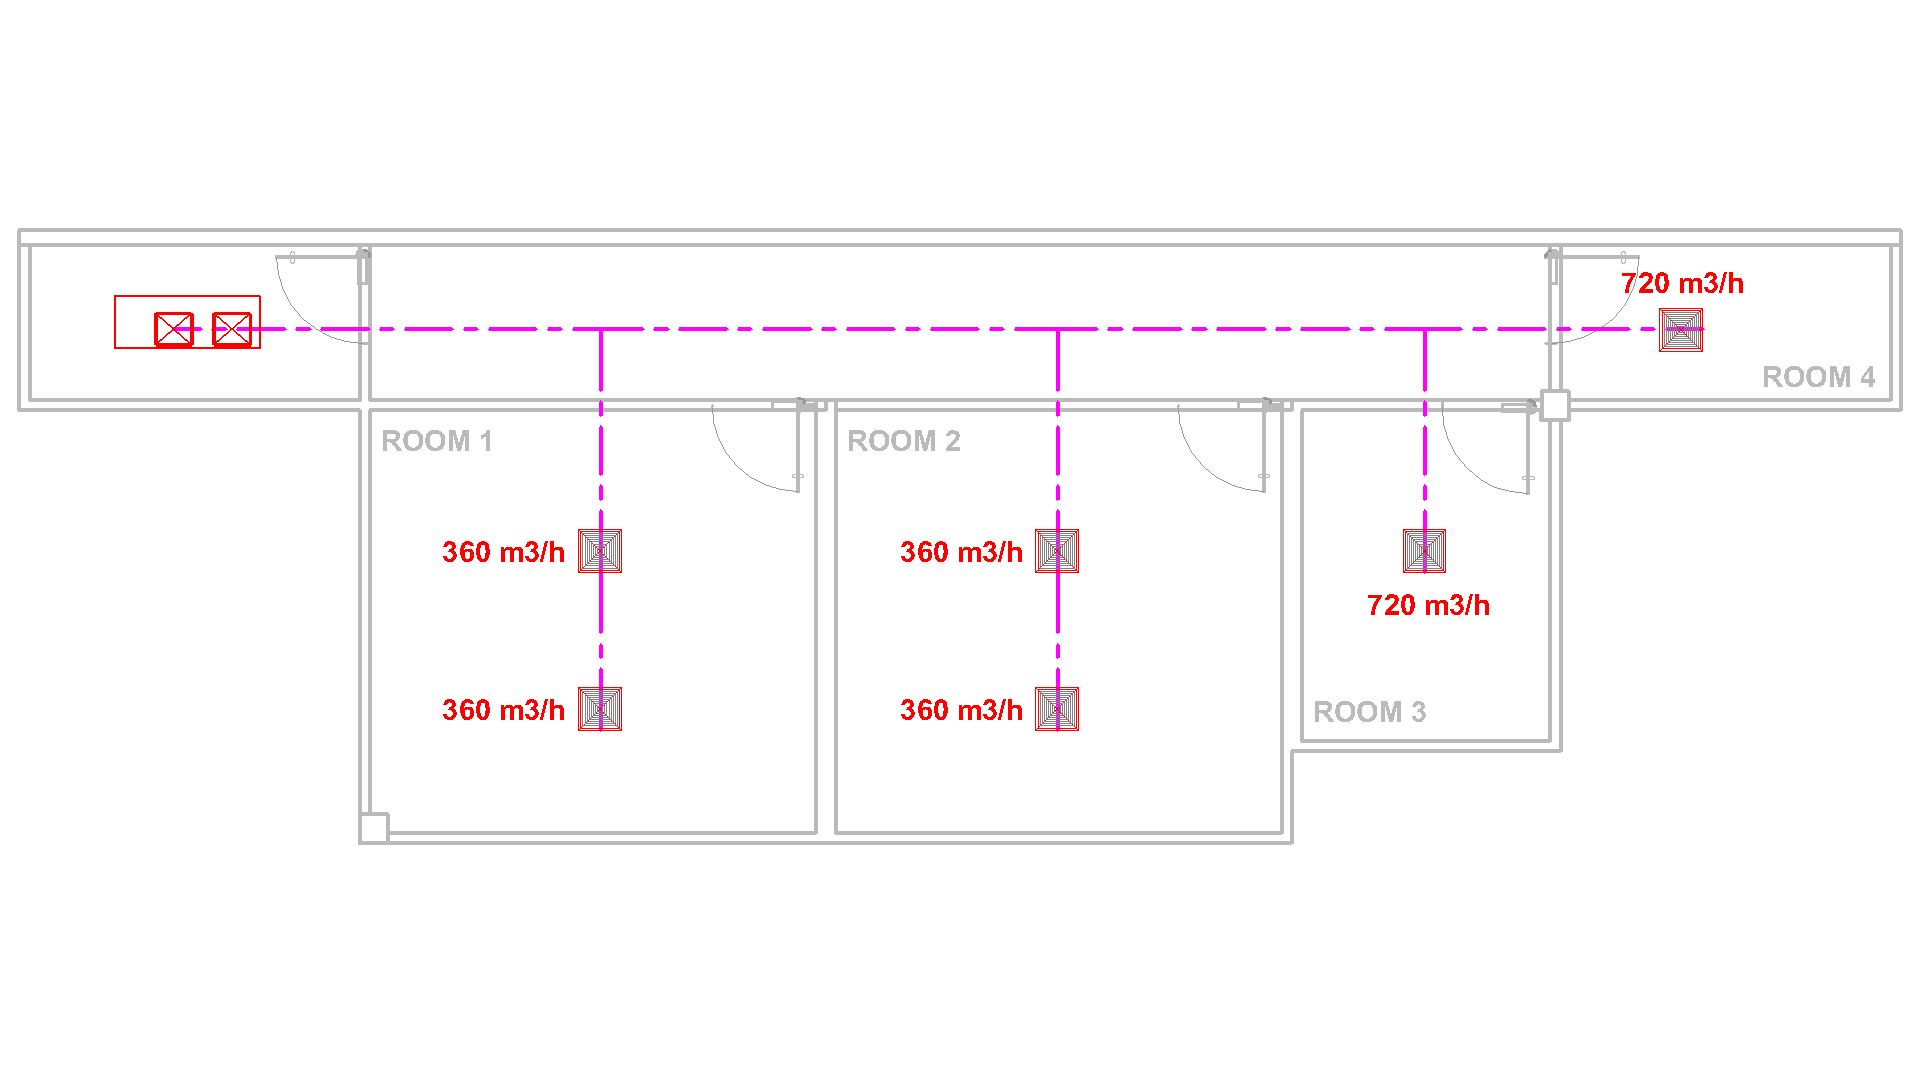


**2**

Divide the ducts into sections and number them using tuples. Then, determine the length of each section

---

*Divida os dutos em seções, numerando-os com tuplas. Em seguida, meça o comprimento de cada seção.*

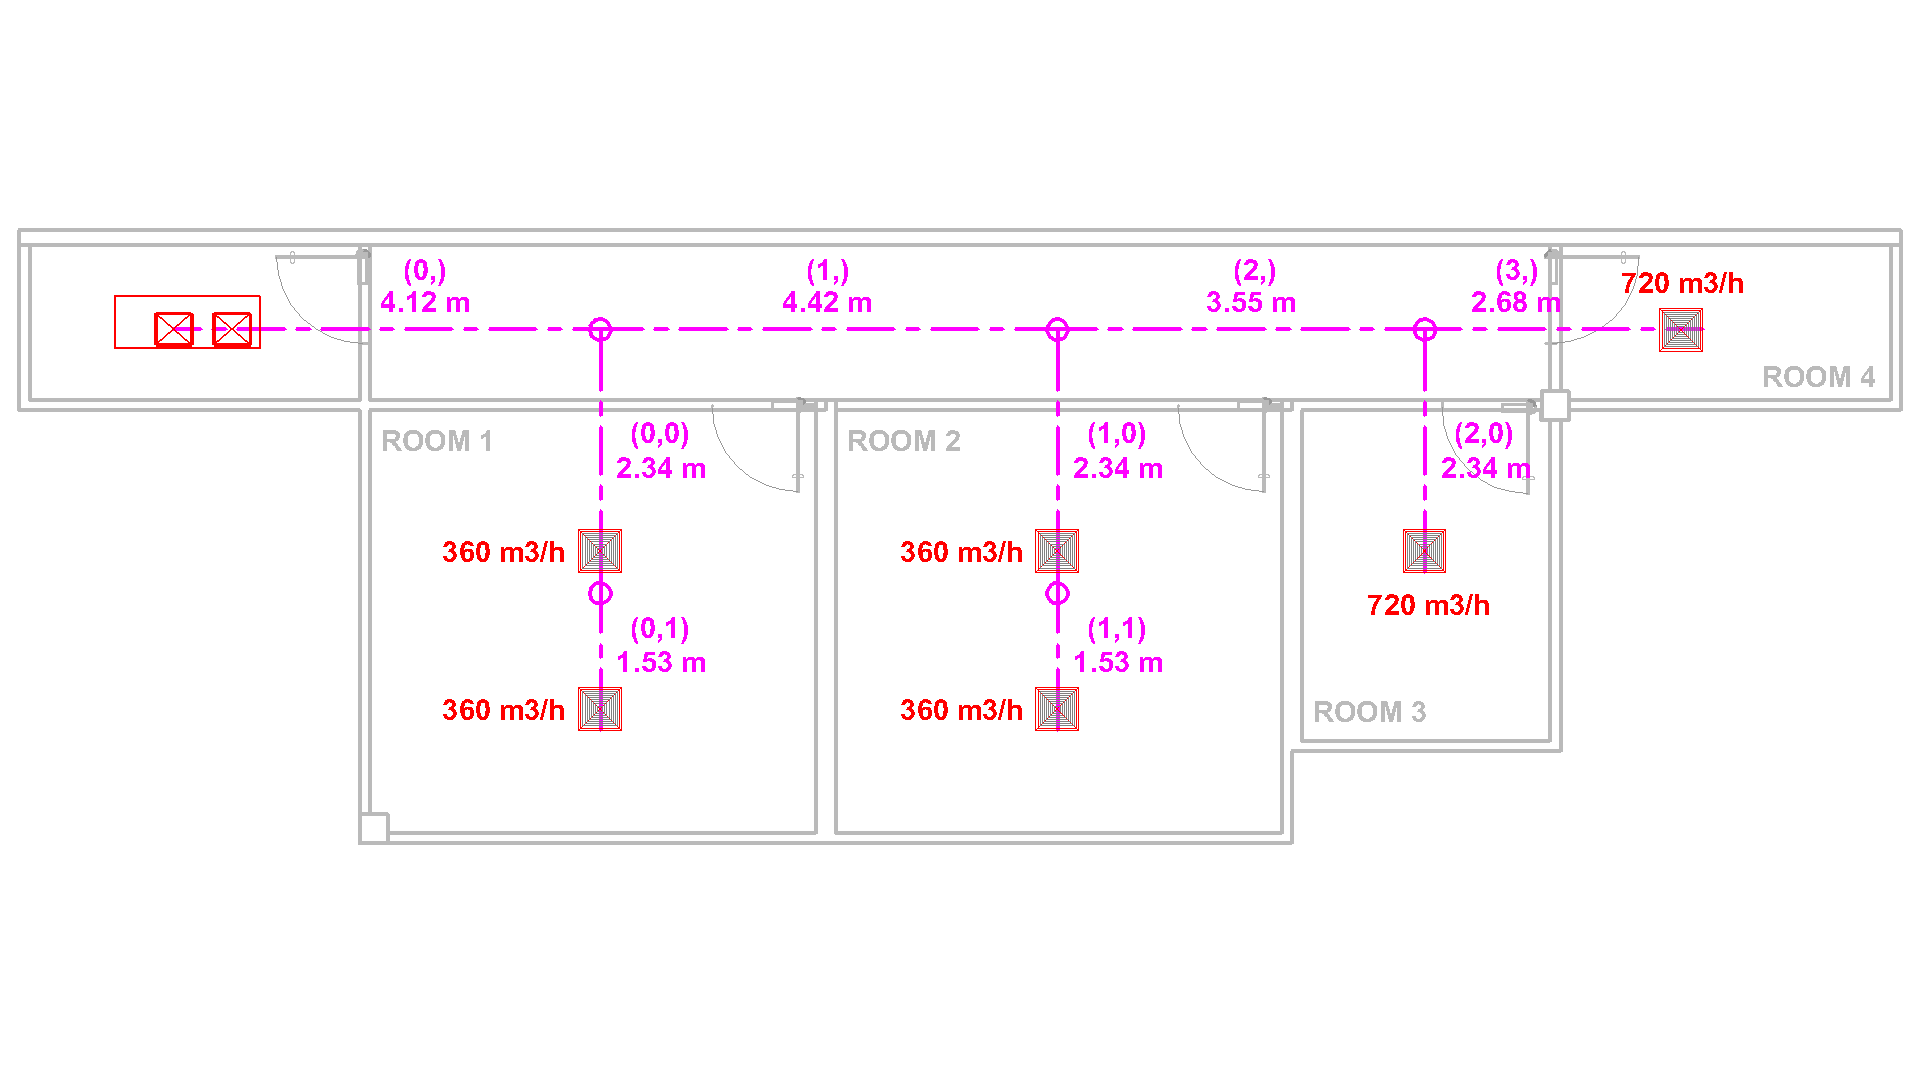

**3**

Configure:

*   Location of each terminal (tuples)
*   Terminal flow rate (m³/h)
*   Duct length (m) for each section in ascending order

---

*Configure:*

*  Localização de cada terminal (representado por tuplas)
*  Vazão do terminal (em m³/h)
*  Comprimento do duto (em metros) para cada seção em ordem crescente

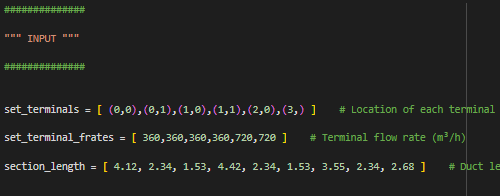


**4**

Set the bounds for air velocity and duct dimensions

---

*Defina os limites para a velocidade do ar e as dimensões do duto.*

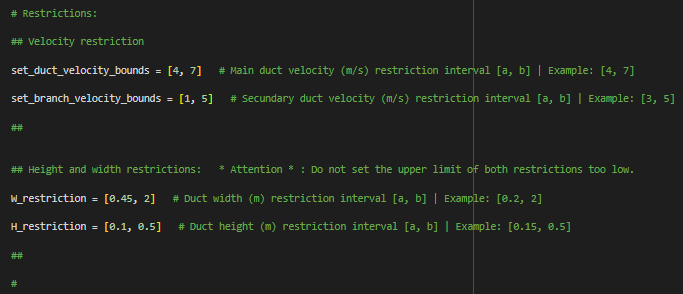

**5**

Run (Ctrl+F9)

---

*Execute (Ctrl+F9)*

**6**

Results:

---

*Resultados:*

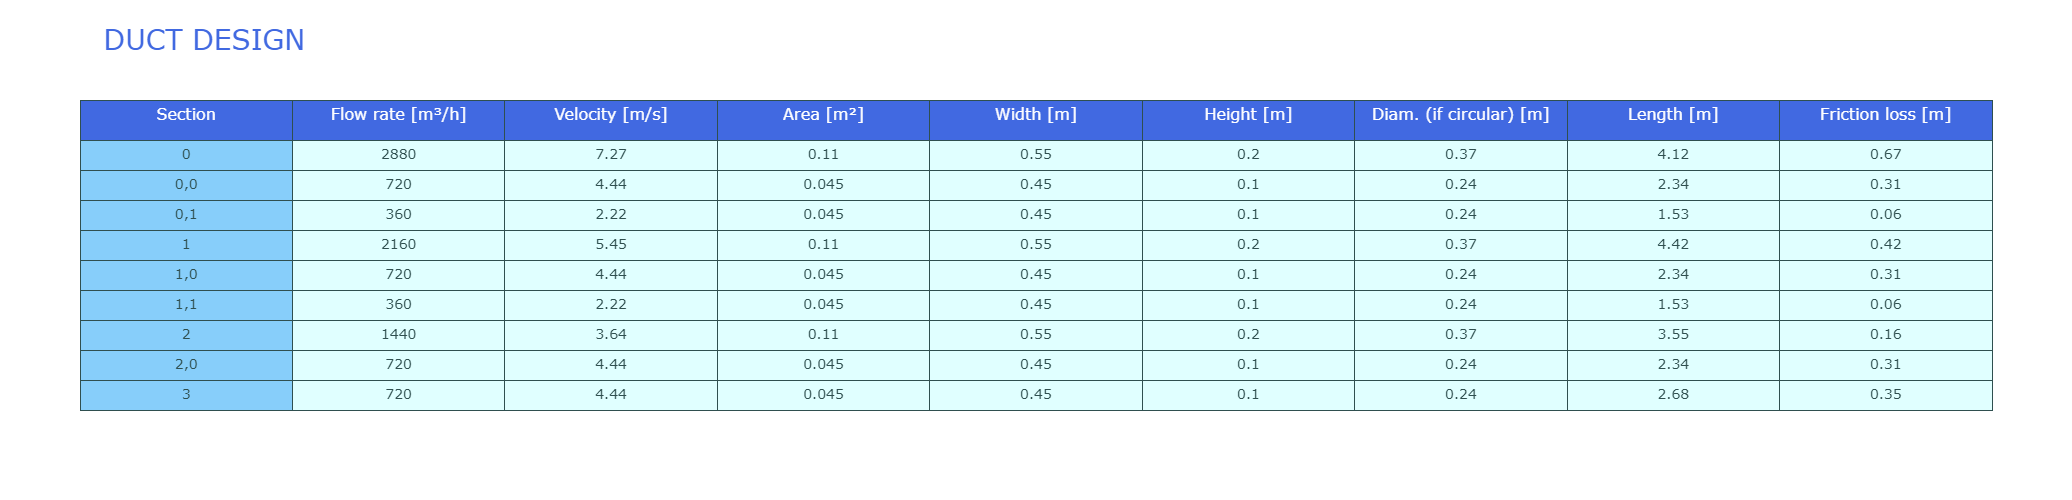

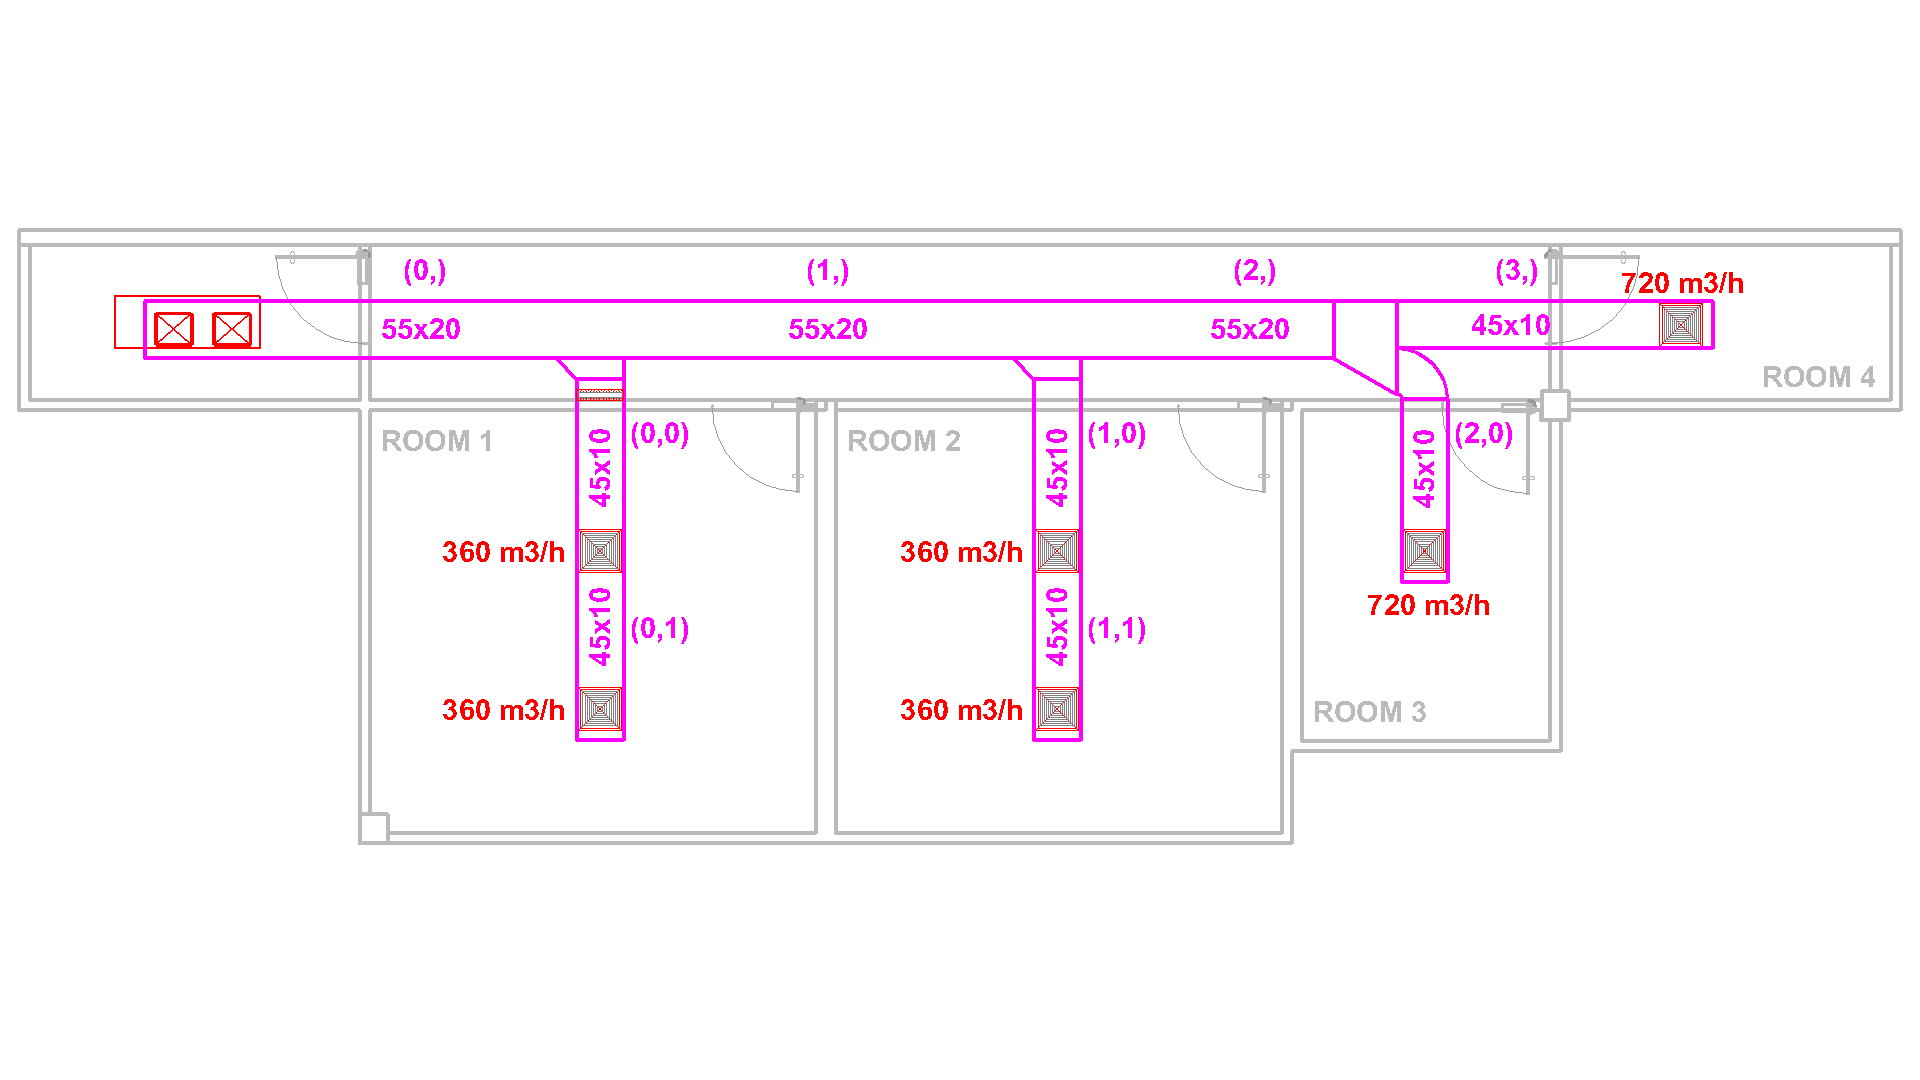


# REFERENCES



1.   ASHRAE Fundamentals Handbook 2001 (SI), Chapter 34: Duct Design, American Society of Heating, Refrigerating & Air Conditioning Engineers, Incorporated  < https://books.google.com.br/books/about/ASHRAE_Fundamentals_Handbook_2001_SI.html?id=S8cJAAAACAAJ&redir_esc=y >
2.   Fluid Mechanics, Frank M. White < https://books.google.com.br/books/about/Fluid_Mechanics.html?id=egk8SQAACAAJ&redir_esc=y >
3.   Ducts Sizing - the Velocity Reduction Method, The EngineeringToolBox < https://www.engineeringtoolbox.com/sizing-ducts-d_207.html >

